# imports

In [68]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [69]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Data preprocessing

In [70]:
df = pd.read_json("Dataset/Sarcasm_Headlines_Dataset.json", lines=True)
df.dropna(inplace=True)
print(df.shape)
df.head()

(26709, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [71]:
# Training Size 70%
# Validation Size 15%
# Testing Size 15%
X_train, X_test, y_train, y_test = train_test_split(np.array(df["headline"]), np.array(df["is_sarcastic"]), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [72]:
print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/df.shape[0],4)*100, "%")
print("Validation set is: ", X_val.shape[0], " rows which is ", round(X_val.shape[0]/df.shape[0],4)*100, "%")
print("Testing set is: ", X_test.shape[0], " rows which is ", round(X_test.shape[0]/df.shape[0],4)*100, "%")

Training set is:  18696  rows which is  70.0 %
Validation set is:  4006  rows which is  15.0 %
Testing set is:  4007  rows which is  15.0 %


# Model

In [73]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

In [74]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = [tokenizer(x, max_length = 100, truncation = True, padding = 'max_length', return_tensors='pt').to(device)
                  for x in X
                 ]
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)
        
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [75]:
class MyModel(nn.Module):
    def __init__(self, bert):

        super(MyModel, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(0.25)
        self.linear1 = nn.Linear(768, 384)
        self.linear2 = nn.Linear(384, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(input_ids, attention_mask, return_dict = False)[0][:,0]
        output = self.linear1(pooled_output)
        output = self.dropout(output)
        output = self.linear2(output)
        output = self.sigmoid(output)
        return output

# Data Loader

In [76]:
BATCH_SIZE = 32
EPOCHS = 25
LR = 1e-4

In [77]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)

In [78]:
for param in bert_model.parameters():
    param.requires_grad = False
model = MyModel(bert_model).to(device)

# Training

In [79]:
loss = nn.BCELoss()
optimizer = Adam(model.parameters(), lr= LR)

In [80]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    ## Training and Validation
    for indx, data in enumerate(train_dataloader):
        input, label = data

        input.to(device)
        label.to(device)

        prediction = model(input['input_ids'].squeeze(1),
                            input['attention_mask'].squeeze(1)).squeeze(1)

        batch_loss = loss(prediction, label)
        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == label).sum().item()
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():
        for indx, data in enumerate(validation_dataloader):
            input, label = data
            input.to(device)
            label.to(device)

            prediction = model(input['input_ids'].squeeze(1),
                            input['attention_mask'].squeeze(1)).squeeze(1)

            batch_loss_val = loss(prediction, label)
            total_loss_val += batch_loss_val.item()


            acc = ((prediction).round() == label).sum().item()

            total_acc_val += acc


    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/100, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/100:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)

Epoch no. 1 Train Loss: 0.2593 Train Accuracy: 80.3969 Validation Loss: 0.4856 Validation Accuracy: 82.9755
Epoch no. 2 Train Loss: 0.2117 Train Accuracy: 84.5582 Validation Loss: 0.4460 Validation Accuracy: 83.8492
Epoch no. 3 Train Loss: 0.1991 Train Accuracy: 85.5958 Validation Loss: 0.4317 Validation Accuracy: 85.0225
Epoch no. 4 Train Loss: 0.1928 Train Accuracy: 85.7135 Validation Loss: 0.4222 Validation Accuracy: 85.6216
Epoch no. 5 Train Loss: 0.1877 Train Accuracy: 86.1040 Validation Loss: 0.4194 Validation Accuracy: 85.8213
Epoch no. 6 Train Loss: 0.1839 Train Accuracy: 86.6549 Validation Loss: 0.4095 Validation Accuracy: 85.9710
Epoch no. 7 Train Loss: 0.1828 Train Accuracy: 86.6389 Validation Loss: 0.4129 Validation Accuracy: 85.8462
Epoch no. 8 Train Loss: 0.1807 Train Accuracy: 86.7512 Validation Loss: 0.4152 Validation Accuracy: 85.9211
Epoch no. 9 Train Loss: 0.1787 Train Accuracy: 86.9330 Validation Loss: 0.4047 Validation Accuracy: 86.0709
Epoch no. 10 Train Loss: 0.1

# Testing

In [81]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, data in enumerate(testing_dataloader):
    input, label = data
    input.to(device)
    label.to(device)

    prediction = model(input['input_ids'].squeeze(1), input['attention_mask'].squeeze(1)).squeeze(1)

    batch_loss_val = loss(prediction, label)
    total_loss_test += batch_loss_val.item()
    acc = ((prediction).round() == label).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 86.35%


# Visualizations

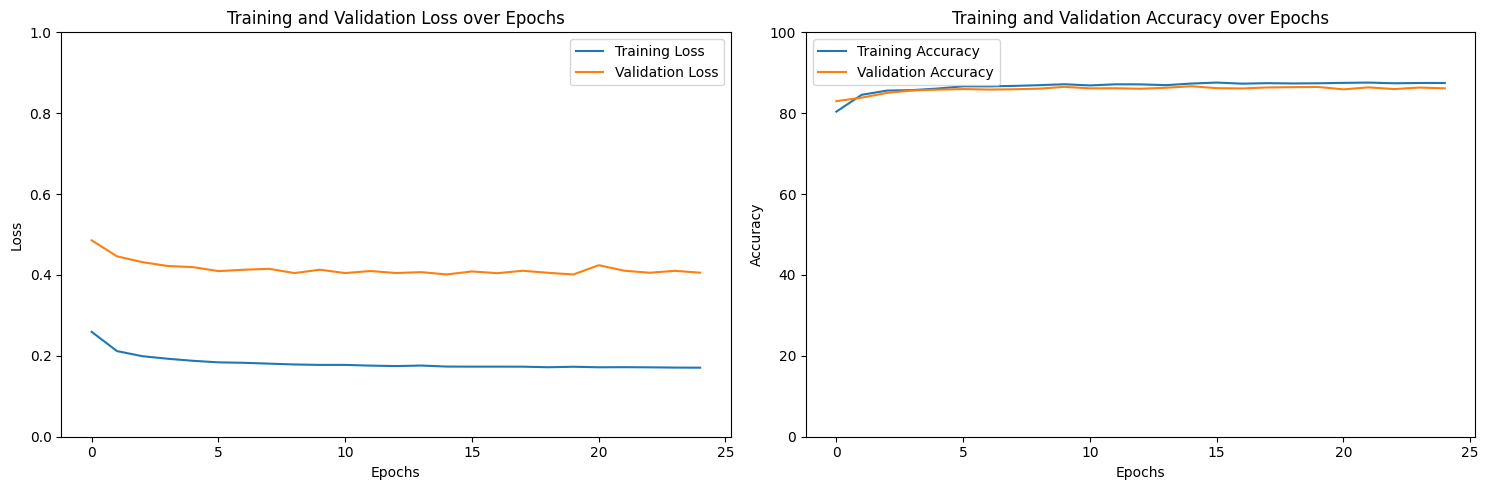

In [83]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()